In [1]:
!pip install pandas scikit-learn optuna statsmodels scikit-optimize

In [2]:
from include.graficos import *
from include.utils import *
import logging
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import statsmodels.api as sm

In [3]:
import seaborn as sns
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

# Carregando os dados processados
dados_originais = pd.read_csv('../planilhas/1_dados_sinteticos.csv', encoding='latin-1')
X_train = pd.read_csv('../planilhas/2_dados_processados_treino.csv', encoding='latin-1')
X_test = pd.read_csv('../planilhas/3_dados_processados_teste.csv', encoding='latin-1')
y_train = pd.read_csv('../planilhas/4_dados_processados_treino_target.csv', encoding='latin-1')
y_test = pd.read_csv('../planilhas/5_dados_processados_teste_target.csv', encoding='latin-1')

# Convertendo y_train em um array unidimensional
y_train = y_train.values.ravel()

# Convertendo y_test em um array unidimensional
y_test = y_test.values.ravel()

# Descartando na predição do modelo, mas trago novamente nos dados futuros
colunas_descartadas_treino = X_train[['Gênero','Região','Categoria_IMC']]
colunas_descartadas_teste = X_test[['Gênero','Região','Categoria_IMC']]
X_train = X_train.drop(colunas_descartadas_treino, axis=1)
X_test = X_test.drop(colunas_descartadas_teste, axis=1)

**2. Limpeza de Dados**

In [5]:
X_train = limpar_dados(X_train)
X_test = limpar_dados(X_test)

In [6]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_train.isnull().sum())
print(f"\nQuantidade de linhas: {X_train.shape[0]}. Quantidade de colunas: {X_train.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade           0
IMC             0
Filhos          0
Fumante         0
Coef_Idade      0
Coef_Filhos     0
Coef_IMC        0
Coef_Fumante    0
dtype: int64

Quantidade de linhas: 8000. Quantidade de colunas: 8


In [7]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_test.isnull().sum())
print(f"\nQuantidade de linhas: {X_test.shape[0]}. Quantidade de colunas: {X_test.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade           0
IMC             0
Filhos          0
Fumante         0
Coef_Idade      0
Coef_Filhos     0
Coef_IMC        0
Coef_Fumante    0
dtype: int64

Quantidade de linhas: 2000. Quantidade de colunas: 8


**3. Pré-processamento**

In [8]:
# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)


Calculando a matriz de correlação entre os dados de treinamento:

Foi detectado que não existe relacionamento válido a ser considerado entre as features.

A única correlação válida é entre o target e algumas features, conforme visto no EDA.


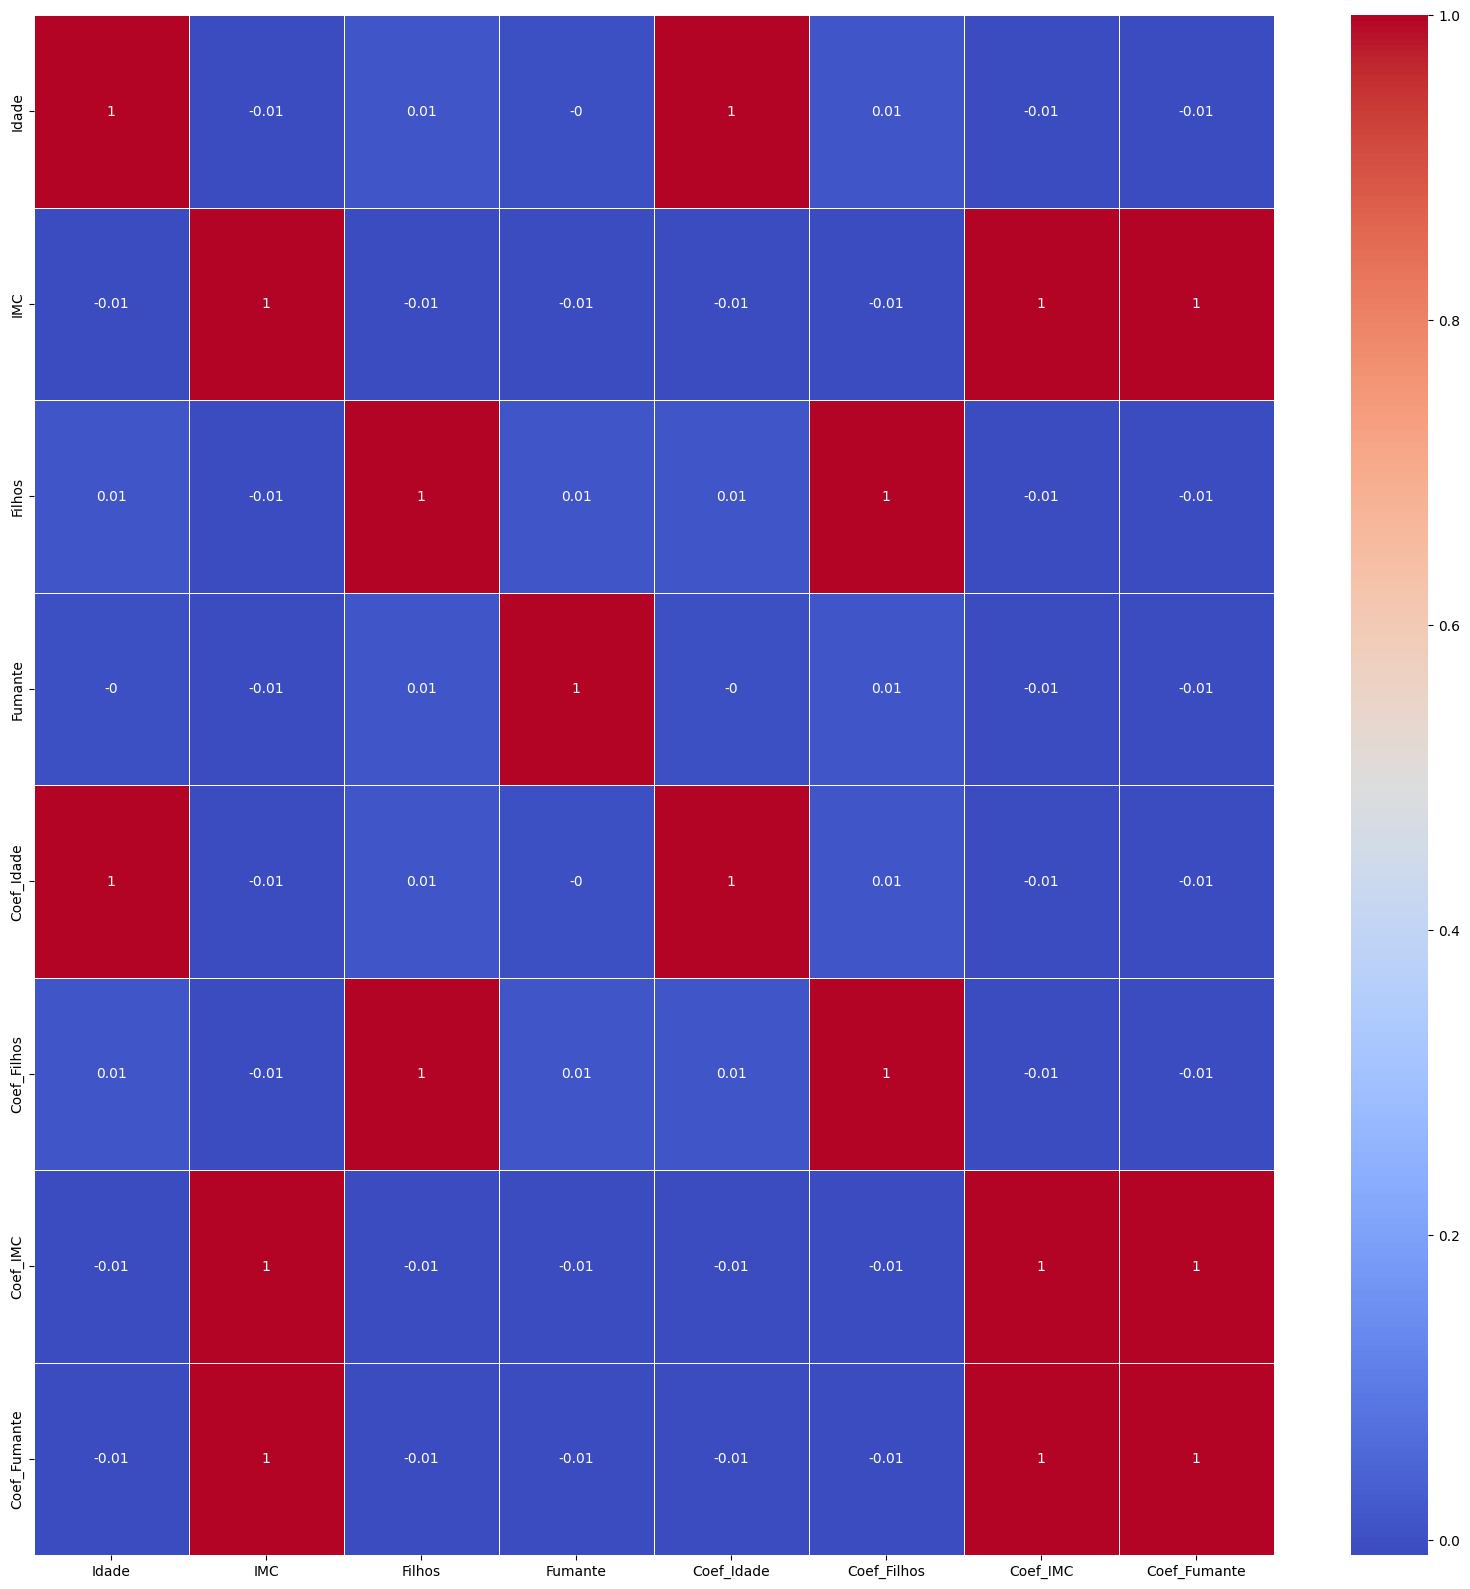

In [9]:
numeric_columns = X_train.select_dtypes(include='number')

print("\nCalculando a matriz de correlação entre os dados de treinamento:")
correlation_matrix = numeric_columns.corr().round(2)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

print("\nFoi detectado que não existe relacionamento válido a ser considerado entre as features.")
print("\nA única correlação válida é entre o target e algumas features, conforme visto no EDA.")

**4. Treinamento do Modelo**

In [10]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge()
}

param_spaces = {
    'Random Forest Regressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': list(range(1, 11)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Support Vector Regression': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear']
    },
    'Decision Tree Regressor': {
        'max_depth': list(range(1, 11)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'K-Nearest Neighbors Regressor': {
        'n_neighbors': list(range(3, 11)),
        'weights': ['uniform', 'distance']
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': list(range(1, 11)),
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10],
        'selection': ['cyclic', 'random']
    },
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [-1]  # Se quiser paralelizar o processo de ajuste
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
}

In [11]:
# Número de interações usado no método abaixo BayesSearchCV (como demora um pouco, caso seja necessário, basta reduzir a quantidade de interações)
numero_interacoes_bayes_search = 3

# Treinamento e avaliação dos modelos com BayesSearchCV
for name, model in models.items():
    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    print(f"Modelo {name}:");
    
    try:
        verificar_se_modelo_tem_dados_nan_inf(model, X_train_scaled, y_train)
        print(f"\nSem NaN e Inf nas previsões do modelo")
    except ValueError as e:
        print(f"{name}: {e}")
    
    if name in param_spaces:
        bayes_search = BayesSearchCV(model, param_spaces[name], cv=5, scoring='neg_mean_squared_error', n_iter=numero_interacoes_bayes_search, random_state=42)
        bayes_search.fit(X_train_scaled, y_train)
        model = bayes_search.best_estimator_
        print(f"\nMelhores parâmetros: {bayes_search.best_params_}")
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_quadrado = r2_score(y_test, y_pred)

    print(f'\nErro Médio Quadrático (MSE): {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f'\nErro Absoluto Médio (MAE): {round(mae.mean(),2)}')
    print(f'\nCoeficiente de determinação (R2): {round(r_quadrado.mean(),2)}')
    print(f'\nAcurácia média com validação cruzada: {round(scores.mean(),2)}')
        
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"\nImportância das características:")
        print(f'\n{round(importance_df,2)}')
    elif isinstance(model, LinearRegression) or isinstance(model, Lasso) or isinstance(model, Ridge):        
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"\nCoeficientes das características:")
        print(f'\n{round(importance_df,2)}')
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"\nImportância das características:")
        print(f'\n{round(importance_df,2)}')
    else:
        print("\nNão é possível calcular a importância das características")

--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Random Forest Regressor:

Sem NaN e Inf nas previsões do modelo

Melhores parâmetros: OrderedDict({'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300})

Erro Médio Quadrático (MSE): 73332.77

Erro Absoluto Médio (MAE): 228.62

Coeficiente de determinação (R2): 0.94

Acurácia média com validação cruzada: 0.94

Importância das características:

        Colunas  Importância
4    Coef_Idade         0.40
0         Idade         0.36
5   Coef_Filhos         0.09
2        Filhos         0.08
3       Fumante         0.05
7  Coef_Fumante         0.01
1           IMC         0.01
6      Coef_IMC         0.01
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Linear 

**5. Comparação de Modelos**

In [12]:
# Seleção de modelo com base na maior pontuação de validação cruzada
best_model_name = max(models, key=lambda model: cross_val_score(models[model], X_train_scaled, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [13]:
best_model = models[best_model_name]
print(f'Melhor modelo: {best_model_name}')

Melhor modelo: Gradient Boosting Regressor


**7. Otimização de Modelo**

In [14]:
# Caso seja necessário, basta aumentar as tentativas de estudo do optuna
numero_tentativas_estudo_optuna = 10

def create_model(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_categorical('n_estimators', param_spaces[best_model_name]['n_estimators'])
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        min_samples_split = trial.suggest_categorical('min_samples_split', param_spaces[best_model_name]['min_samples_split'])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', param_spaces[best_model_name]['min_samples_leaf'])
        max_features = trial.suggest_categorical('max_features', param_spaces[best_model_name]['max_features'])
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        min_samples_split = trial.suggest_categorical('min_samples_split', param_spaces[best_model_name]['min_samples_split'])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', param_spaces[best_model_name]['min_samples_leaf'])
        model = DecisionTreeRegressor(max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Support Vector Regression':
        C = trial.suggest_categorical('C', param_spaces[best_model_name]['C'])
        gamma = trial.suggest_categorical('gamma', param_spaces[best_model_name]['gamma'])
        kernel = trial.suggest_categorical('kernel', param_spaces[best_model_name]['kernel'])
        model = SVR(C=C, gamma=gamma, kernel=kernel)
    elif best_model_name == 'Linear Regression':
        fit_intercept = trial.suggest_categorical('fit_intercept', param_spaces[best_model_name]['fit_intercept'])
        copy_X = trial.suggest_categorical('copy_X', param_spaces[best_model_name]['copy_X'])
        n_jobs = trial.suggest_categorical('n_jobs', param_spaces[best_model_name]['n_jobs'])
        model = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)
    elif best_model_name == 'K-Nearest Neighbors Regressor':
        n_neighbors = trial.suggest_categorical('n_neighbors', param_spaces[best_model_name]['n_neighbors'])
        weights = trial.suggest_categorical('weights', param_spaces[best_model_name]['weights'])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    elif best_model_name == 'Gradient Boosting Regressor':
        n_estimators = trial.suggest_categorical('n_estimators', param_spaces[best_model_name]['n_estimators'])
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        learning_rate = trial.suggest_categorical('learning_rate', param_spaces[best_model_name]['learning_rate'])
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    elif best_model_name == 'Lasso Regression':
        alpha = trial.suggest_categorical('alpha', param_spaces[best_model_name]['alpha'])
        selection = trial.suggest_categorical('selection', param_spaces[best_model_name]['selection'])
        model = Lasso(alpha=alpha, selection=selection)
    elif best_model_name == 'Ridge Regression':
        alpha = trial.suggest_float('alpha', param_spaces[best_model_name]['alpha'][0], param_spaces[best_model_name]['alpha'][-1])
        fit_intercept = trial.suggest_categorical('fit_intercept', param_spaces[best_model_name]['fit_intercept'])
        solver = trial.suggest_categorical('solver', param_spaces[best_model_name]['solver'])
        model = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver)
    else:
        model = models[best_model_name]  # Usar os hiperparâmetros padrão para outros modelos
    return model

# Função para otimização de hiperparâmetros
def objective(trial):
    # Criar uma nova instância do modelo com hiperparâmetros definidos pelo Optuna
    model = create_model(trial)
    
    # Avaliação do modelo utilizando validação cruzada
    score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Criar o objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# Realizar a otimização dos hiperparâmetros
study.optimize(objective, n_trials=numero_tentativas_estudo_optuna)

[I 2024-04-19 18:04:29,142] A new study created in memory with name: no-name-4eeac4fc-982b-49e3-a190-c928adfa214a
[I 2024-04-19 18:04:32,757] Trial 0 finished with value: -71107.80496855608 and parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2}. Best is trial 0 with value: -71107.80496855608.
[I 2024-04-19 18:04:34,967] Trial 1 finished with value: -71010.04477332137 and parameters: {'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.2}. Best is trial 0 with value: -71107.80496855608.
[I 2024-04-19 18:04:37,028] Trial 2 finished with value: -97009.03807471377 and parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}. Best is trial 2 with value: -97009.03807471377.
[I 2024-04-19 18:04:40,327] Trial 3 finished with value: -95170.17593618999 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}. Best is trial 2 with value: -97009.03807471377.
[I 2024-04-19 18:04:41,376] Trial 4 finished with value: -72073.52824321958 and 

In [15]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params
best_score = study.best_value

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento com os melhores parâmetros
best_model.fit(X_train_scaled, y_train)

# Avaliação do modelo após o ajuste com os melhores parâmetros
score_train = best_model.score(X_train_scaled, y_train)
score_test = best_model.score(X_test_scaled, y_test)

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_quadrado = r2_score(y_test, y_pred)

# Imprimir resultados
print(f"\nModelo:", best_model_name)
print("\nMelhores parâmetros:", best_params)
print("\nMelhor score:", round(best_score,2))
print(f"\nScore treino: {round(score_train,2)}")
print(f"\nScore teste: {round(score_test,2)}")
print(f'\nErro Médio Quadrático (MSE): {round(mse,2)}')
print(f'\nErro Absoluto Médio (MAE): {round(mae.mean(),2)}')
print(f'\nCoeficiente de determinação (R2): {round(r_quadrado.mean(),2)}')


Modelo: Gradient Boosting Regressor

Melhores parâmetros: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}

Melhor score: -97009.04

Score treino: 0.93

Score teste: 0.92

Erro Médio Quadrático (MSE): 94700.45

Erro Absoluto Médio (MAE): 254.96

Coeficiente de determinação (R2): 0.92


In [16]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")


Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
        Colunas  Importância
0         Idade         0.42
4    Coef_Idade         0.36
2        Filhos         0.10
5   Coef_Filhos         0.07
3       Fumante         0.05
7  Coef_Fumante         0.01
1           IMC         0.00
6      Coef_IMC         0.00

Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
                 Idade  Coef_Idade    Filhos  Coef_Filhos   Fumante  \
Idade         1.000000    1.000000  0.006928     0.006928 -0.000005   
Coef_Idade    1.000000    1.000000  0.006928     0.006928 -0.000005   
Filhos        0.006928    0.006928  1.000000     1.000000  0.014222   
Coef_Filhos   0.006928    0.006928  1.000000     1.000000  0.014222   
Fumante      -0.000005   -0.000005  0.014222     0.014222  1.000000   
Coef_Fumante -0.006366   -0.006366 -0.006692    -0.006692 -0.011003   
IMC          -0.006366   -0.006366 -0

In [17]:
# Validação cruzada para detecção de overfitting
def overfitting_detection(model, X_train_scaled, y_train, X_test_scaled, y_test, cv=5):
    train_mse = -cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    test_mse = mean_squared_error(y_test, model.predict(X_test_scaled))
    return train_mse, test_mse

train_mse, test_mse = overfitting_detection(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

print("Erro Médio Quadrático (MSE) no conjunto de treinamento:", round(train_mse,2))
print("Erro Médio Quadrático (MSE) no conjunto de teste:", round(test_mse,2))

Erro Médio Quadrático (MSE) no conjunto de treinamento: 97050.92
Erro Médio Quadrático (MSE) no conjunto de teste: 94700.45


**8. Entrega dos dados futuros**

In [18]:
# Código comentado, mas mantido para estudos futuros
# Copiando X_test para tratar as transformações feitas e usar abaixo para randomizar os dados futuros
# X_test_aux = X_test.copy()

# Inserir as colunas descartadas em X_test
# for coluna in colunas_descartadas_treino.columns:
#    X_test_aux.insert(loc=len(X_test_aux.columns), column=coluna, value=colunas_descartadas_treino[coluna])

# print(X_test_aux.head(50))

# Lista para armazenar as colunas que passaram por LabelEncoder
# colunas_label_encoded = []

# Verifica quais colunas passaram por LabelEncoder
# for coluna in dados_originais.columns:
#    if dados_originais[coluna].dtype == 'object' and X_test_aux[coluna].dtype == 'int64':
#        colunas_label_encoded.append(coluna)

# print(colunas_label_encoded)

# Ajuste o LabelEncoder aos dados de treinamento original
# label_encoder = LabelEncoder()
# label_encoder.fit(dados_originais['Fumante'])

# Revertendo a codificação de rótulos
# fumante_aux = label_encoder.inverse_transform(X_test_aux['Fumante'])
# X_test_aux.insert(X_test_aux.columns.get_loc('Fumante') + 1, 'Fumante2', fumante_aux)
# print(X_test_aux.head(50))

In [19]:
# Variável necessária para geração dos dados futuros (mantivemos uma menor quantidade para poder ver melhor no gráfico visto posteriormente)
novas_linhas_dados_futuros = 100

# Criando um novo dataset, respeitando a quantidade de novas linhas indicadas, assim como seguindo as mesmas features do X_test
dados_futuros = gerar_dados_futuros_com_limites(novas_linhas=novas_linhas_dados_futuros, x_test=X_test)

# Aplicando a mesma transformação de padronização aos dados futuros
dados_futuros_scaled = scaler.transform(dados_futuros)

# Modelo treinado para fazer previsões dos encargos futuros
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros_scaled)

# Grupos de indivíduos com diferentes níveis de risco
grupos_risco = segmentacao_de_risco(best_model, dados_futuros_scaled)

# Utilizando as previsões dos encargos para otimizar a alocação de recursos
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

# Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros_scaled)

# Gerando algumas previsões futuras
encargos_futuros_fixo_70_anos = previsao_por_coluna(model, dados_futuros_scaled, indice_coluna=0, novo_valor=70)
print(f'\n10 primeiras previsões com idade = 70 anos:\n{encargos_futuros_fixo_70_anos[:10]}')

encargos_futuros_fixo_75_anos = previsao_por_coluna(model, dados_futuros_scaled, indice_coluna=0, novo_valor=75)
print(f'\n10 primeiras previsões com idade = 75 anos:\n{encargos_futuros_fixo_75_anos[:10]}')

encargos_futuros_fixo_80_anos = previsao_por_coluna(model, dados_futuros_scaled, indice_coluna=0, novo_valor=80)
print(f'\n10 primeiras previsões com idade = 80 anos:\n{encargos_futuros_fixo_80_anos[:10]}')


10 primeiras previsões com idade = 70 anos:
[33457.75, 34208.46, 34507.4, 33787.81, 33397.04, 34519.75, 34057.09, 33537.0, 34243.9, 34626.42]

10 primeiras previsões com idade = 75 anos:
[35878.16, 36628.86, 36927.81, 36208.22, 35817.45, 36940.16, 36477.5, 35957.4, 36664.3, 37046.83]

10 primeiras previsões com idade = 80 anos:
[38298.57, 39049.27, 39348.22, 38628.62, 38237.86, 39360.57, 38897.9, 38377.81, 39084.71, 39467.23]


In [20]:
# Ajustando o LabelEncoder aos dados de treinamento original
label_encoder = LabelEncoder()
label_encoder.fit(dados_originais['Fumante'])

# Revertendo a codificação de rótulos
dados_futuros['Fumante'] = label_encoder.inverse_transform(dados_futuros['Fumante'])

# Inserindo as colunas descartadas em X_test
for coluna in colunas_descartadas_treino.columns:
    dados_futuros.insert(loc=len(dados_futuros.columns), column=coluna, value=colunas_descartadas_treino[coluna])

# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargos Reais'] = obter_encargo_por_coeficientes(dados_futuros, novas_linhas_dados_futuros)
dados_futuros['Encargos Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Encargo Futuro - Fixo 70 anos'] = encargos_futuros_fixo_70_anos
dados_futuros['Encargo Futuro - Fixo 75 anos'] = encargos_futuros_fixo_75_anos
dados_futuros['Encargo Futuro - Fixo 80 anos'] = encargos_futuros_fixo_80_anos
dados_futuros['Otimização Recursos'] = recursos_otimizados
dados_futuros['Planos estratégicos'] = planos_estrategicos

# Salvando os dados randômicos futuros
dados_futuros.to_csv("../planilhas/7_dados_futuros.csv", index=False, encoding='latin1')

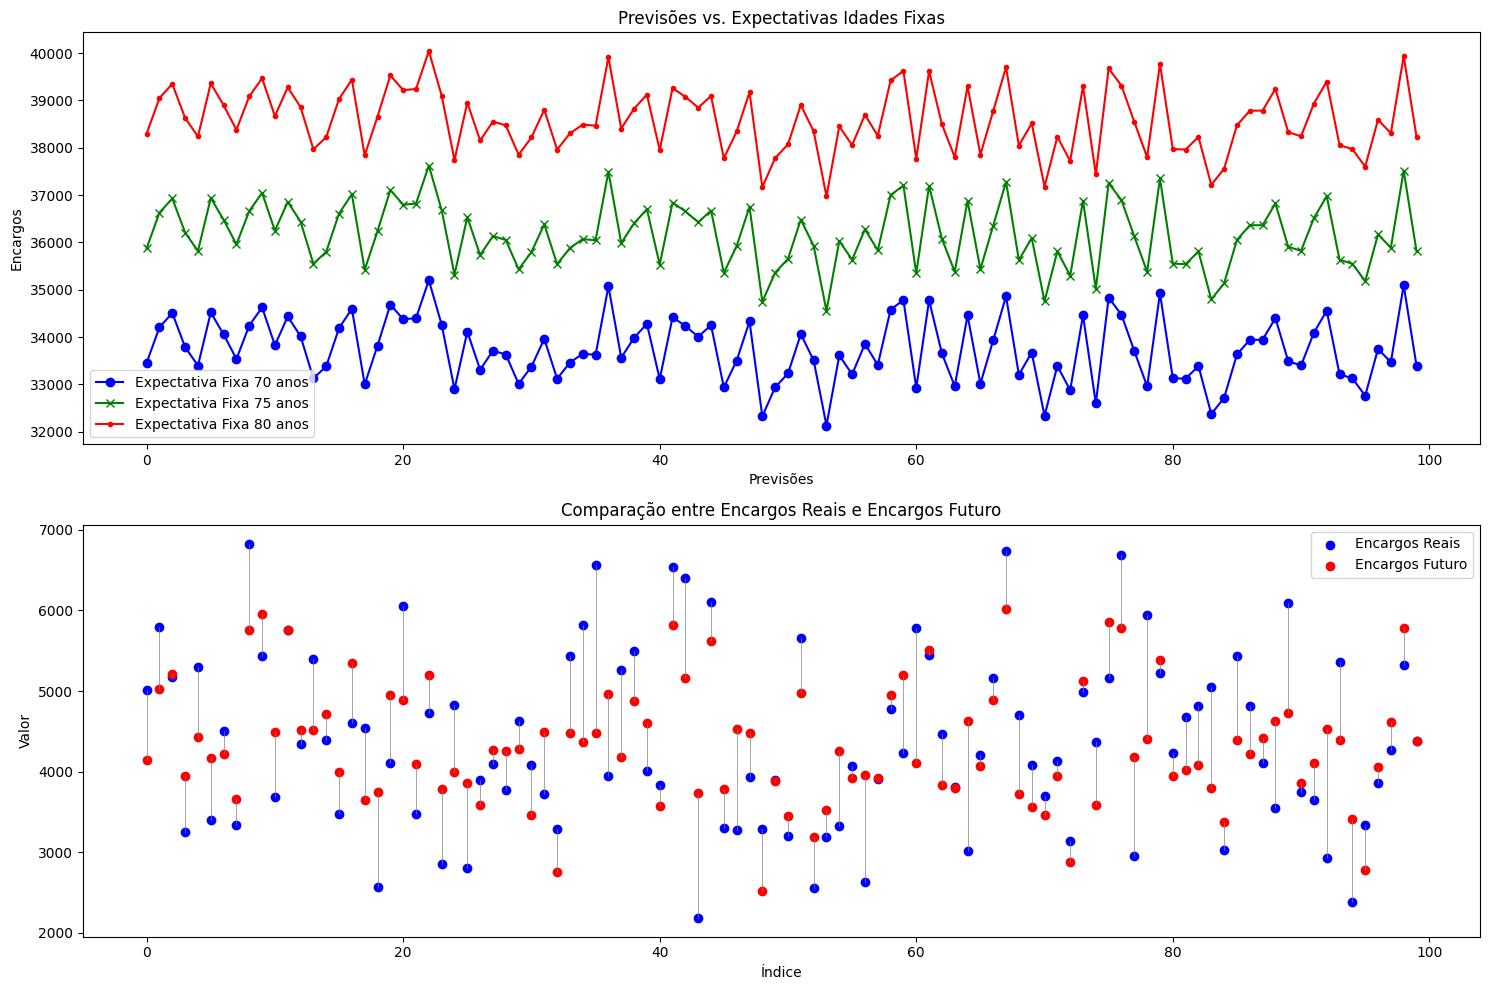

In [21]:
# Exibindo os gráficos com as previsões futuras
montar_graficos_dados_futuros(dados_futuros)